In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# для работы с файлами
import glob

# для создания моих суррготаных моделей
import MY_SOLVERS as mysol

# для проверки суррогатных моделей
import sklearn.metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# для отслеживания прогресса
from tqdm import tqdm

# Чтение данных

In [2]:
regimes = (pd.read_csv("./data/regimes.csv")).drop(['Num'],axis=1)
total_FC = pd.DataFrame(columns=['Cx', 'Cy'], data=np.zeros((regimes.shape[0],2))) #FC - force coefficient

files = glob.glob("results/*_*_*")
files.sort()
for i,path in tqdm(enumerate(files)):
    f = open(path, mode='r')

    l = f.readlines()[22]
    sep_words = l.split()

    total_FC.iloc[i][0] = float(sep_words[-3])
    total_FC.iloc[i][1] = float(sep_words[-2])

    f.close()

64it [00:00, 825.37it/s]


In [3]:
regimes

,M,alpha
0,0.94648,-3.71875
1,0.83867,-2.40625
2,0.81289,5.84375
3,0.84102,3.59375
4,0.89727,2.65625
...,...,...
59,0.85273,4.34375
60,0.82930,0.78125
61,0.85039,-3.34375
62,0.89258,4.90625


In [4]:
total_FC

,Cx,Cy
0,0.083398,-0.298906
1,0.024050,-0.136088
2,0.080494,0.784640
3,0.046048,0.701913
4,0.043631,0.510899
...,...,...
59,0.060453,0.723859
60,0.021536,0.316106
61,0.035199,-0.238177
62,0.078851,0.708251


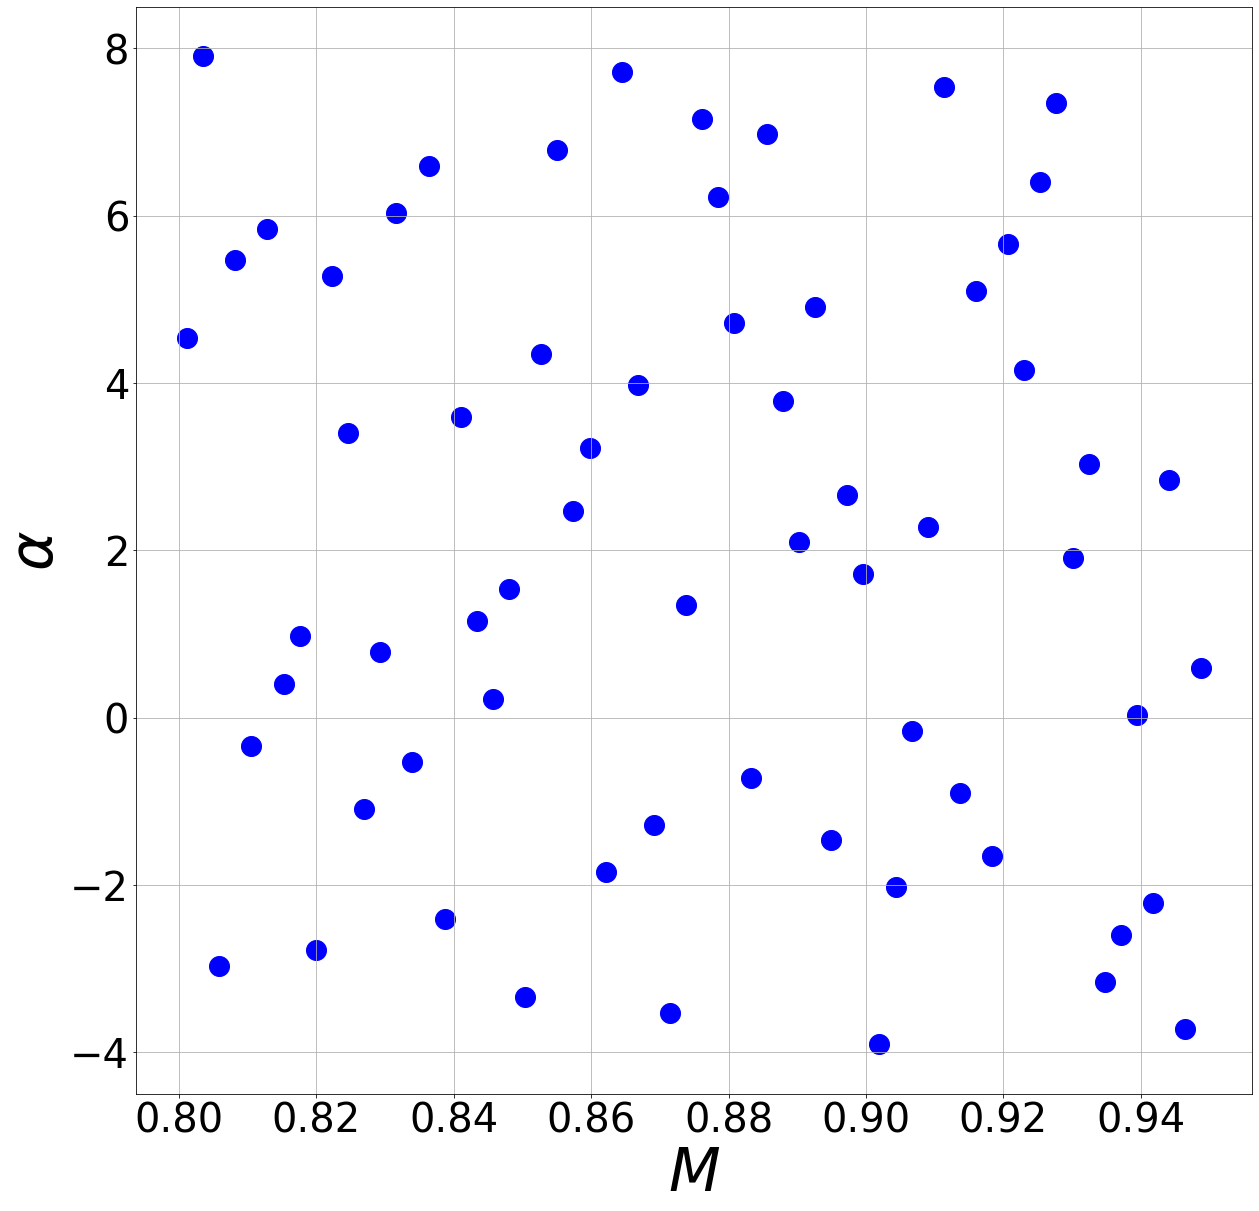

In [7]:
size = 20
plt.figure(figsize=(size,size))

plt.scatter(regimes['M'], regimes['alpha'], marker='.', c='blue', s=size*80)
plt.xlabel(r"$M$", size=3*size)
plt.xticks(size=2*size)
plt.ylabel(r"$\alpha$", size=3*size)
plt.yticks(size=2*size)
plt.grid()

plt.savefig("/home/ruslan/Рабочий стол/ФИЗТЕХ/Научная_работа/pictures/DOE/doe_точки80голубой.png", format='png', transparent=True)

# Обучение моделей на всей выборке

In [5]:
kw_args_for_sm = {
    'print_global' : False,
    'noise0' : [0],
    'eval_noise' : False,
    'use_het_noise' : False,
    'theta0' : [0.1],
    'corr' : 'matern52',
    'poly' : 'quadratic'
    }
sm_names = ['KRG', 'KRG']
coef_for_predict = ["Cx", "Cy"]

model = mysol.CxCy_PREDICTOR(sm_names=sm_names,
                             list_kw_args=kw_args_for_sm, 
                             coef_for_predict=coef_for_predict, 
                             debug=False)
model.fit(regimes=regimes, target=total_FC)

# построение сетки предсказаний

In [6]:
import itertools

In [7]:
Mach_min, Mach_max, Mach_mean = min(regimes['M']), max(regimes['M']), np.mean(regimes['M'])
NMach = 100
Mach = np.linspace(Mach_min, Mach_max, NMach)

angle_min, angle_max, angle_mean = min(regimes['alpha']), max(regimes['alpha']), np.mean(regimes['alpha'])
NAngle = 100
Angle = np.linspace(angle_min, angle_max, NAngle)

prod = np.array([pair for pair in itertools.product(Mach, Angle)])
pred_regimes = pd.DataFrame(data=prod, columns=['M', 'alpha'])
predicts = model.predict(pred_regimes)

# Построение полей

In [11]:
def plot_field(regimes, ForceCoef, size=8, levelsf=100, levels=5, alpha=0.75, linewidths=0.6):
    size = size
    plt.figure(figsize=(size*2, size))
    
    #______________________________________________________________________#
    plt.subplot(1,2,1)
    plt.title(r"$C_x$", size=3*size)
    
    plt.tricontourf(regimes['M'], regimes['alpha'], ForceCoef['Cx'], 
                    levels=levelsf, cmap='viridis')
    cbar = plt.colorbar()
    contour = plt.tricontour(regimes['M'], regimes['alpha'], ForceCoef['Cx'], extend='both',
                             linewidths=linewidths, colors='k', alpha=alpha, levels=levels)
    plt.clabel(contour, fontsize=10, fmt='%1.2f')
    
    plt.xlabel(r"$M$", size=2*size)
    plt.ylabel(r"$\alpha$", size=2*size)
    plt.xticks(size=1.5*size)
    plt.yticks(size=1.5*size)
    
    
    #______________________________________________________________________#
    plt.subplot(1,2,2)
    plt.title(r"$C_y$", size=3*size)
    
    plt.tricontourf(regimes['M'], regimes['alpha'], ForceCoef['Cy'], 
                    levels=levelsf, cmap='viridis')
    cbar = plt.colorbar()
    contour = plt.tricontour(regimes['M'], regimes['alpha'], ForceCoef['Cy'], extend='both',
                             linewidths=linewidths, colors='k', alpha=alpha, levels=levels)
    plt.clabel(contour, fontsize=10, fmt='%1.2f')
    
    plt.xlabel(r"$M$", size=2*size)
    plt.ylabel(r"$\alpha$", size=2*size)
    plt.xticks(size=1.5*size)
    plt.yticks(size=1.5*size)

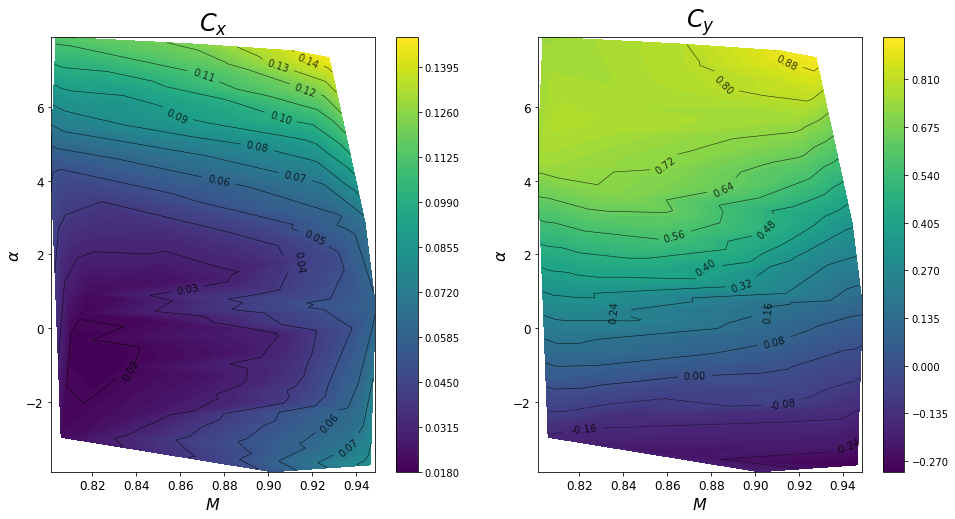

In [12]:
# Распределение в обучающей выборке
plot_field(regimes, total_FC, levels=15, levelsf=100)

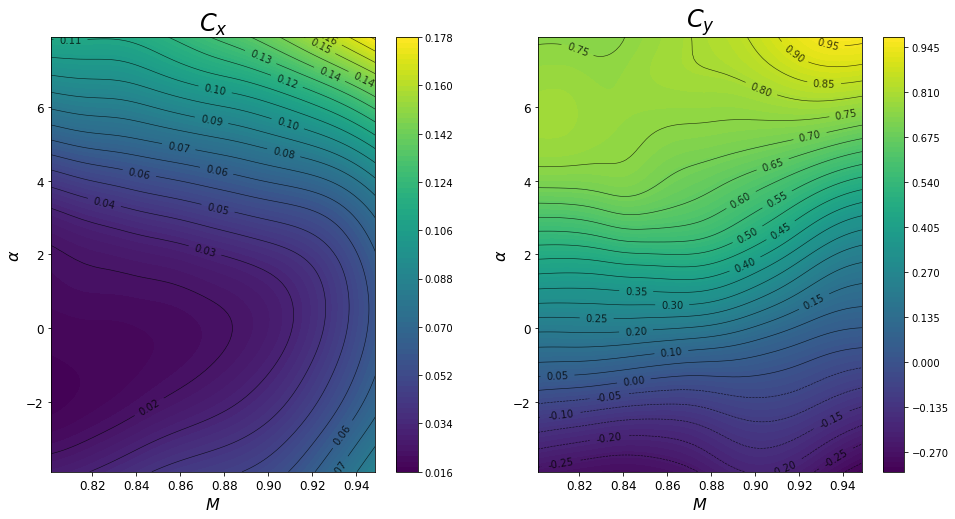

In [13]:
# Распределение, полученное суррогатной моделью
plot_field(pred_regimes, predicts, levels=25, levelsf=100)